# Bank Fraud Dataset에 대한 Plug and Play XAI 적용

## BAF(Bank Account Fraud)

### Real-world online bank account opening fraud detection dataset

Data : https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022


Paper : https://arxiv.org/pdf/2211.13358

|                                  | Description                                                                              |
|:---------------------------------|:-----------------------------------------------------------------------------------------|
| fraud_bool                       | Fraud label (1 if fraud, 0 if legit)                                                     |
| income                           | Annual income of the applicant in quantiles. Ranges between [0, 1].                      |
| name_email_similarity            | Metric of similarity between email and applicant’s                                       |
|                                  | name. Higher values represent higher similarity. Ranges between [0, 1].                  |
| prev_address_months_count        | : Number of months in previous registered                                                |
|                                  | address of the applicant, i.e. the applicant’s previous residence, if applicable. Ranges |
|                                  | between [−1, 380] months (-1 is a missing value).                                        |
| current_address_months_count     | Months in currently registered address of                                                |
|                                  | the applicant. Ranges between [−1, 406] months (-1 is a missing value).                  |
| customer_age                     | Applicant’s age in bins per decade (e.g, 20-29 is represented as 20).                    |
| days_since_request               | Number of days passed since application was done.                                        |
|                                  | Ranges between [0, 78] days.                                                             |
| intended_balcon_amount           | Initial transferred amount for application.                                              |
|                                  | Ranges between [−1, 108].                                                                |
| payment_type                     | Credit payment plan type. 5 possible (annonymized)                                       |
|                                  | values.                                                                                  |
| zip_count_4w                     | Number of applications within same zip code in last 4 weeks.                             |
|                                  | Ranges between [1, 5767].                                                                |
| velocity_6h                      | Velocity of total applications made in last 6 hours i.e., average                        |
|                                  | number of applications per hour in the last 6 hours. Ranges between [−211, 24763].       |
| velocity_24h                     | Velocity of total applications made in last 24 hours i.e., average                       |
|                                  | number of applications per hour in the last 24 hours. Ranges between [1329, 9527].       |
| velocity_4w                      | Velocity of total applications made in last 4 weeks, i.e., average                       |
|                                  | number of applications per hour in the last 4 weeks. Ranges between [2779, 7043].        |
| bank_branch_count_8w             | Number of total applications in the selected bank                                        |
|                                  | branch in last 8 weeks. Ranges between [0, 2521].                                        |
| date_of_birth_distinct_emails_4w | Number of emails for applicants with                                                     |
|                                  | same date of birth in last 4 weeks. Ranges between [0, 42].                              |
| employment_status                | Employment status of the applicant. 7 possible                                           |
|                                  | (annonymized) values.                                                                    |
| credit_risk_score                | Internal score of application risk. Ranges between                                       |
|                                  | [−176, 387].                                                                             |
| email_is_free                    | Domain of application email (either free or paid).                                       |
| housing_status                   | Current residential status for applicant. 7 possible                                     |
|                                  | (annonymized) values.                                                                    |
| phone_home_valid                 | Validity of provided home phone.                                                         |
| phone_mobile_valid               | Validity of provided mobile phone.                                                       |
| bank_months_count                | How old is previous account (if held) in months.                                         |
|                                  | Ranges between [−1, 31] months (-1 is a missing value).                                  |
| has_other_cards                  | If applicant has other cards from the same banking company.                              |
| proposed_credit_limit            | Applicant’s proposed credit limit. Ranges between                                        |
|                                  | [200, 2000].                                                                             |
| foreign_request                  | If origin country of request is different from bank’s country.                           |
| source                           | Online source of application. Either browser(INTERNET) or mobile app                     |
|                                  | (APP).                                                                                   |
| session_length_in_minutes        | Length of user session in banking website in                                             |
|                                  | minutes. Ranges between [−1, 107] minutes                                                |
| device_os                        | Operative system of device that made request. Possible values                            |
|                                  | are: Windows, Macintox, Linux, X11, or other.                                            |
| keep_alive_session               | User option on session logout.                                                           |
| device_distinct_emails_8w        | Number of distinct emails in banking website from                                        |
|                                  | the used device in last 8 weeks. Ranges between [0, 3].                                  |
| device_fraud_count               | Number of fraudulent applications with used device.                                      |
|                                  | Ranges between [0, 1].                                                                   |
| month                            | Month where the application was made. Ranges between [0, 7].                             |

In [1]:
import os
import pickle

import torch
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from shap import KernelExplainer
import quantus as qt

from pnpxai.explainers import KernelShap, Lime, LRP, IntegratedGradients
import qt_wrapper as qtw
from model import TabResNet

from shap.plots import waterfall as shap_waterfall_plot
from shap import Explanation

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are no

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Load Data

In [3]:
# Load test data
with open("data/baf/preprocess/X_test.npy", 'rb') as f:
    X_test = np.load(f)

with open("data/baf/preprocess/y_test.npy", 'rb') as f:
    y_test = np.load(f)

test_df = pd.read_csv("data/baf/preprocess/test.csv", index_col=0)

# Load meta data
with open("data/baf/preprocess/metadata.pkl", 'rb') as f:
    meta = pickle.load(f)

# Load Model

In [4]:
model_nn = TabResNet(X_test.shape[1], 2)
model_nn.load_state_dict(torch.load("models/baf/tabresnet.pth"))
model_nn = torch.nn.Sequential(model_nn, torch.nn.Softmax(dim=1))
model_nn.eval()
pass

# Get Explanation

In [5]:
sample_size = 100
sample_data = X_test[np.random.choice(X_test.shape[0], sample_size, replace=False)]
dataset = torch.utils.data.TensorDataset(torch.tensor(sample_data, dtype=torch.float32))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=sample_data.shape[0], shuffle=False)
X = next(iter(dataloader))[0]
targets = model_nn(X).detach()

In [6]:
# # Explain models
# shap = KernelShap(model_nn)
# baselines = torch.zeros(X.shape[1])

# shap_values = shap.attribute(
#     inputs=X,
#     targets=targets.argmax(dim=1),
#     baselines=baselines,
#     n_samples=400,
#     feature_mask=torch.arange(X.shape[1]).unsqueeze(0),
# )

# # LIME
# lime = Lime(model_nn)
# baselines = torch.zeros(X.shape[1])

# lime_values = lime.attribute(
#     inputs=X,
#     targets=targets.argmax(dim=1),
#     baselines=baselines,
#     n_samples=400,
#     feature_mask=torch.arange(X.shape[1]).unsqueeze(0),
# )

# # LRP
# lrp = LRP(model_nn)
# lrp_values = lrp.attribute(
#     inputs=X,
#     targets=targets.argmax(dim=1),
# )

# # IG
# ig = IntegratedGradients(model_nn)
# baselines = torch.zeros(X.shape[1])

# ig_values = ig.attribute(
#     inputs=X,
#     targets=targets.argmax(dim=1),
# )


# def attr_agg(attr):
#     feature_names = meta["float_cols"].tolist() + list(meta["cat_cols"].keys())
#     aggr = pd.DataFrame(index=np.arange(X.shape[0]), columns=feature_names)
#     aggr.loc[:, meta["float_cols"]] = attr[:, :len(meta["float_cols"])]
#     start = len(meta["float_cols"])
#     for col in meta['cat_cols'].keys():
#         aggr.loc[:, col] = attr[:, start:start + len(meta['cat_cols'][col])].sum(axis=1)
#     return aggr

# shap_values_df = attr_agg(shap_values.detach().numpy())
# lime_values_df = attr_agg(lime_values.detach().numpy())
# lrp_values_df = attr_agg(lrp_values.detach().numpy())
# ig_values_df = attr_agg(ig_values.detach().numpy())

# # Save explanations
# if not os.path.exists("explanations"):
#     os.makedirs("explanations")

# shap_values_df.to_csv("explanations/shap_values.csv")
# lime_values_df.to_csv("explanations/lime_values.csv")
# lrp_values_df.to_csv("explanations/lrp_values.csv")
# ig_values_df.to_csv("explanations/ig_values.csv")

In [7]:
# # Save targets in explanations folder with np.save
# targets = targets.detach().numpy()
# np.save("explanations/targets.npy", targets)

In [8]:
STOP

NameError: name 'STOP' is not defined

In [9]:
shap_values_df = pd.read_csv("explanations/shap_values.csv", index_col=0)
lime_values_df = pd.read_csv("explanations/lime_values.csv", index_col=0)
lrp_values_df = pd.read_csv("explanations/lrp_values.csv", index_col=0)
ig_values_df = pd.read_csv("explanations/ig_values.csv", index_col=0)


In [10]:
shap_values_df

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,...,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,payment_type,employment_status,housing_status,source,device_os
0,0.068253,-0.045070,0.048693,0.009573,0.026028,-0.008245,-0.000075,-0.038285,-0.001425,0.000034,...,-0.000434,0.003883,0.040490,-0.000358,-0.001030,-0.049593,0.019391,0.019391,-0.056509,-0.049593
1,0.071334,0.002669,0.054700,-0.010676,-0.003396,-0.006859,0.017699,0.005574,0.011310,-0.000460,...,-0.004794,-0.007214,0.049160,0.000112,0.014619,0.104399,0.175339,0.175339,-0.003108,0.104399
2,-0.036858,0.011914,-0.031727,0.022550,-0.007279,0.005699,0.005623,0.021510,-0.004733,0.004529,...,-0.001676,-0.011815,0.024238,0.005919,-0.004140,0.023548,-0.009602,-0.009602,0.033108,0.023548
3,-0.018700,-0.052781,-0.014334,-0.010123,0.011832,-0.000545,0.003788,0.008025,-0.006622,0.015459,...,0.003163,-0.011210,0.018650,-0.001249,-0.003218,0.011123,-0.015587,-0.015587,0.004305,0.011123
4,0.003074,0.006214,-0.037461,0.033931,0.011826,0.002814,0.009574,0.014469,-0.001085,0.007875,...,0.001923,0.002172,0.012215,0.006745,-0.002243,-0.005269,-0.010726,-0.010726,0.000013,-0.005269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.029815,-0.050924,-0.030469,-0.012494,-0.018044,0.008284,-0.007506,0.011252,0.013122,0.009967,...,0.002890,-0.079960,-0.031805,0.011296,0.001666,0.001121,-0.003567,-0.003567,0.008462,0.001121
96,0.027620,0.012618,0.049358,-0.028188,0.125353,-0.005183,0.017466,-0.050216,0.002598,-0.014892,...,-0.011457,0.011762,0.071162,-0.012684,0.001810,0.116316,0.188013,0.188013,-0.004427,0.116316
97,0.016162,-0.055415,-0.031938,0.043273,-0.010622,-0.000759,-0.002783,0.039641,-0.001259,0.009713,...,-0.003395,0.036340,-0.019626,0.004082,0.001406,0.006800,-0.030376,-0.030376,0.006345,0.006800
98,-0.013607,-0.119501,-0.041716,0.050008,-0.006788,-0.012417,0.053503,-0.001576,-0.006258,0.041942,...,0.004707,-0.007438,-0.042379,-0.003897,-0.001815,-0.027342,-0.085577,-0.085577,-0.012772,-0.027342


In [ ]:
def beeswarm_plot(data, target, title):
    plt.figure(figsize=(10, 10))
    plt.title(title)

    # Melt the DataFrame
    df_melted = data.melt(var_name='Feature', value_name='Value')

    # Convert values to numeric, coercing errors
    df_melted['Value'] = pd.to_numeric(df_melted['Value'], errors='coerce')

    # Add the 'target' column back to the melted DataFrame
    df_melted['target'] = np.tile(target[:, 1], data.shape[1])

    sns.swarmplot(
        data=df_melted,
        x='Value',
        y='Feature',
        hue='target',
        orient="h", size=5, palette="coolwarm", warn_thresh=0.9
    )

    plt.grid()
    plt.show()

def waterfall_plot(data, target, idx, max_display=20):
    fx = target[idx, 1].item()
    exp = Explanation(
        data.loc[[idx]].values,
        base_values=np.array([fx-data.loc[[idx]].values.sum()]),
        data=test_df[meta["float_cols"].tolist() + list(meta["cat_cols"].keys())].iloc[idx].astype(str).values.reshape(1, -1),
        feature_names=data.columns,
    )

    shap_waterfall_plot(exp[0], max_display=max_display)


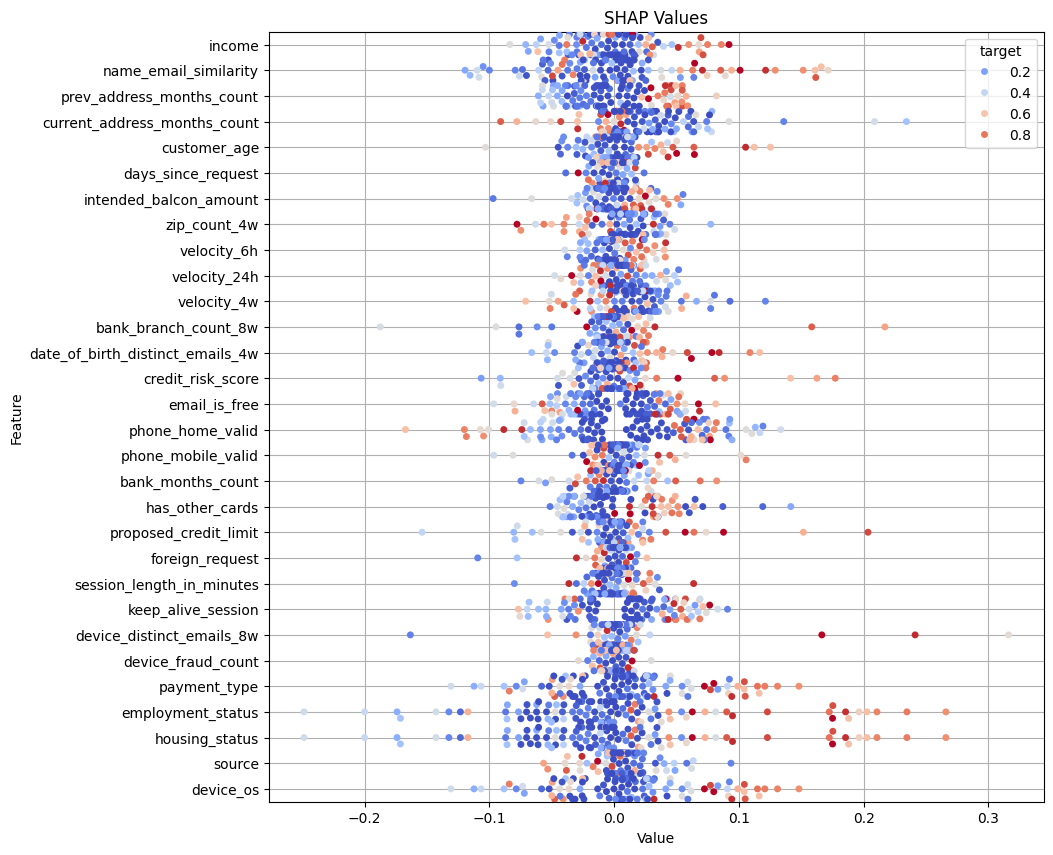

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 97.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 93.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 96.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 91.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/cwl/miniconda3/envs/pn

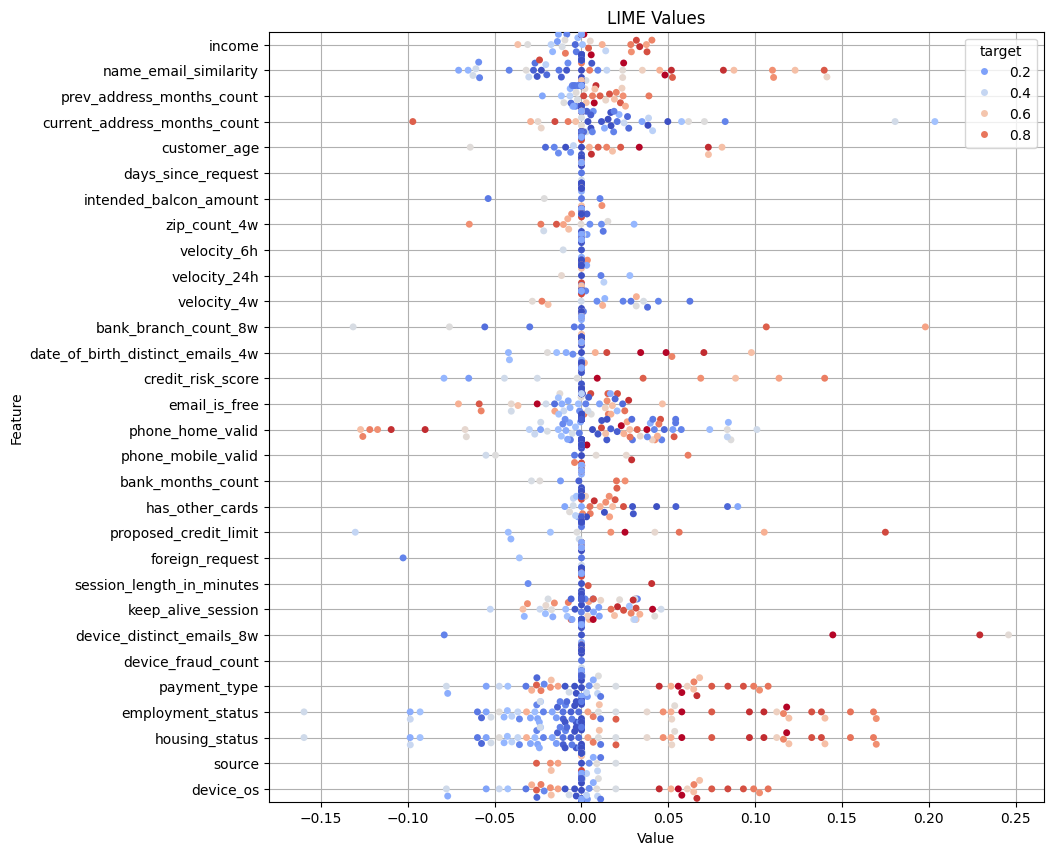

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 91.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 97.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


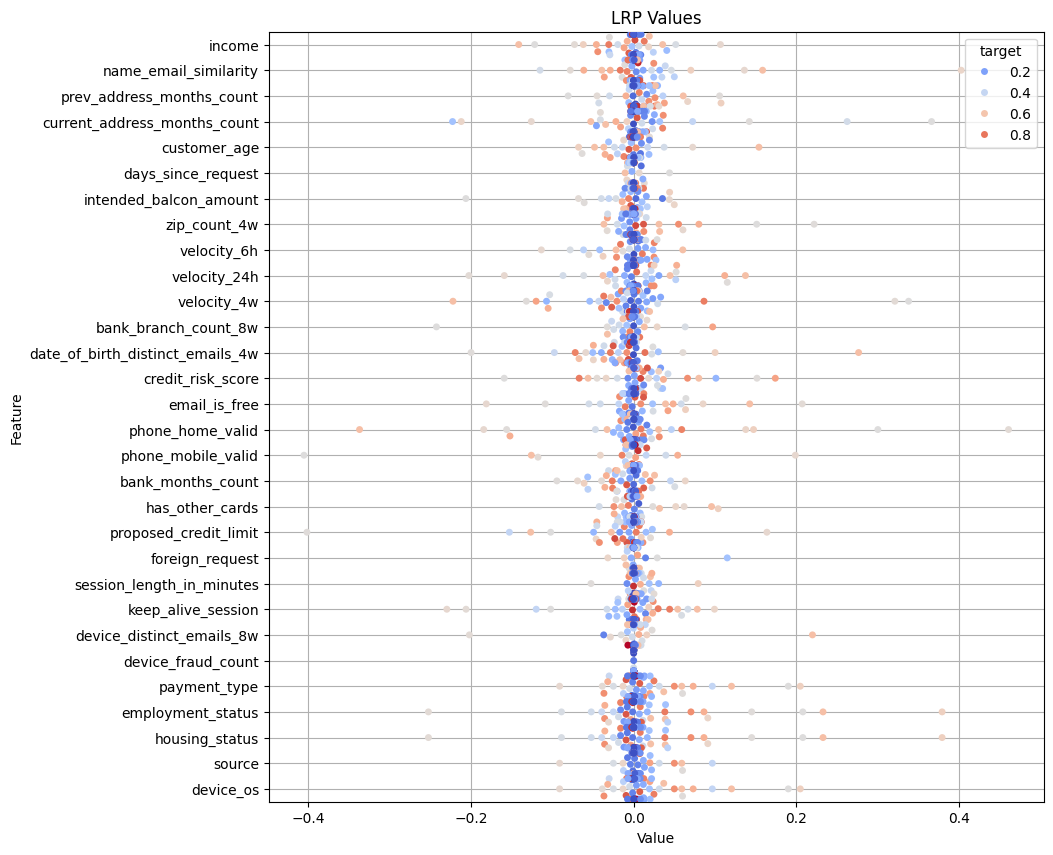

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 93.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 95.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 92.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 97.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


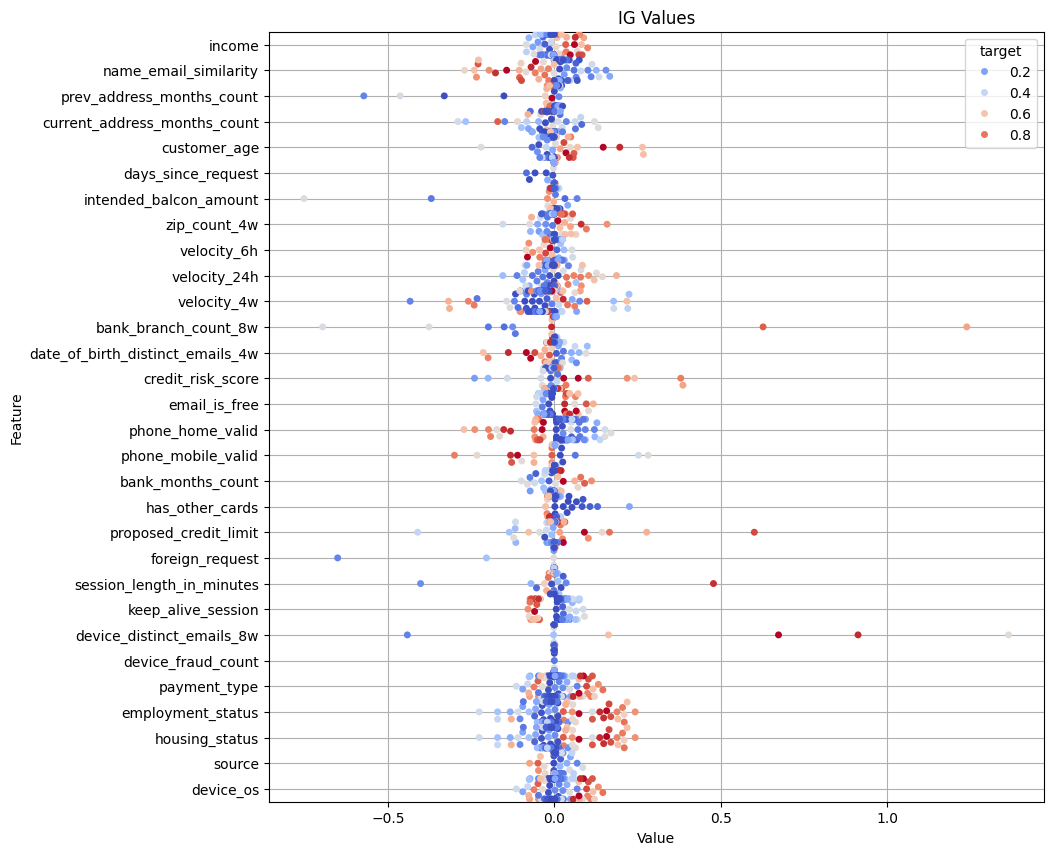

In [ ]:
beeswarm_plot(shap_values_df, targets, "SHAP Values")
beeswarm_plot(lime_values_df, targets, "LIME Values")
beeswarm_plot(lrp_values_df, targets, "LRP Values")
beeswarm_plot(ig_values_df, targets, "IG Values")

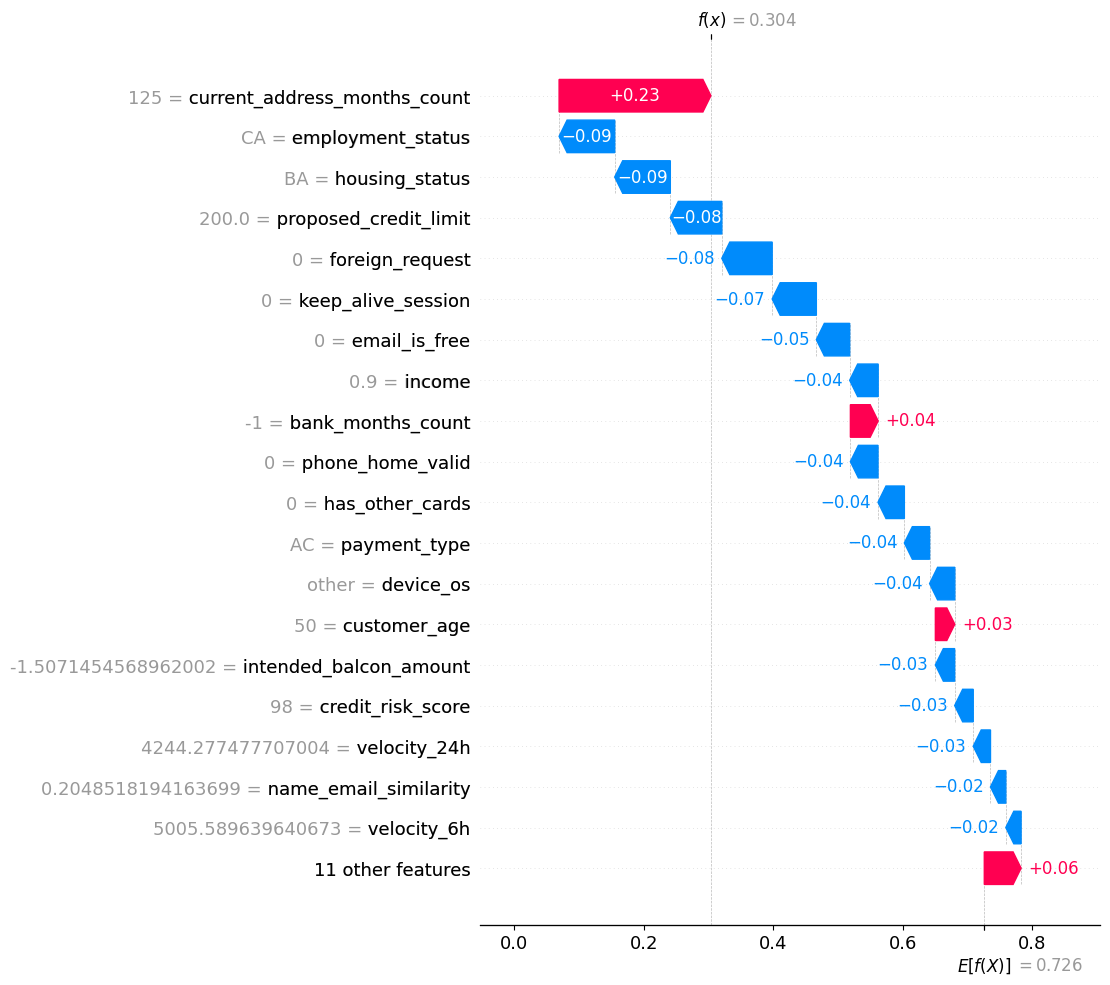

In [ ]:
waterfall_plot(shap_values_df, targets, 50)